Evaluating trained tuned lens.
Tuned lens vs logit lens comparison for a couple of examples

In [1]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

clear_output()

from nnsight import CONFIG

CONFIG.set_default_api_key("CyGxYcKP2LsxYbsWJoZp")

In [2]:
# Load llama3.1
llama = LanguageModel("meta-llama/Meta-Llama-3.1-8B",device="cuda")
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [3]:
# All we need to specify using NDIF vs executing locally is remote=True.
with llama.trace("The Eiffel Tower is in the city of", remote=True) as runner:

    hidden_states = llama.model.layers[-1].output.save()

    output = llama.output.save()
    t1_tokens_out = llama.lm_head.output.argmax(dim=-1).save()

print(hidden_states)

print(output["logits"])
print(t1_tokens_out)
print("Original Prediction: ", llama.tokenizer.decode(t1_tokens_out[0][-1]))

2024-09-22 17:58:22,683 0577cb12-7322-4959-98d8-cac9c9a8fc8a - RECEIVED: Your job has been received and is waiting approval.
2024-09-22 17:58:22,707 0577cb12-7322-4959-98d8-cac9c9a8fc8a - APPROVED: Your job was approved and is waiting to be run.
2024-09-22 17:58:22,740 0577cb12-7322-4959-98d8-cac9c9a8fc8a - RUNNING: Your job has started running.
2024-09-22 17:58:23,107 0577cb12-7322-4959-98d8-cac9c9a8fc8a - COMPLETED: Your job has been completed.

(tensor([[[ 1.7734,  2.6875,  0.8047,  ..., -1.8594,  2.2344,  3.2812],
         [ 0.0352, -0.0430, -2.8750,  ..., -0.8906, -0.0508,  1.6094],
         [ 1.3594, -2.0469,  1.6953,  ..., -1.6875, -0.7539,  1.4297],
         ...,
         [ 1.0078,  0.3125, -0.2852,  ..., -0.0830, -0.2471,  0.2217],
         [ 0.4824, -0.3555,  0.2188,  ...,  0.7422, -0.0078,  0.1133],
         [-0.0557, -0.3652,  0.4648,  ...,  0.9688,  0.6719, -0.8789]]],
       dtype=torch.bfloat16), DynamicCache())
tensor([[[ 6.3438,  8.3750, 12.8125,  ..., -4.3750, -4.3750, -4.3750],
         [-2.4531, -1.7031, -2.0000,  ..., -9.1250, -9.1250, -9.1250],
         [ 9.6875,  4.5938,  5.8750,  ..., -3.3906, -3.3906, -3.3906],
         ...,
         [ 2.3281,  1.0312, -0.3301,  ..., -7.1562, -7.1562, -7.1562],
         [11.2500,  6.0312,  4.9062,  ..., -3.5000, -3.5000, -3.5000],
         [ 8.0625,  5.2500,  4.3750,  ..., -3.9531, -3.9531, -3.9531]]])
tensor([[14924,   220, 10426,   301, 22703,   374,   264, 12366,  409

In [6]:
import torch.nn.functional as F
import numpy as np
def run_lens(model,PROMPT):
    logits_lens_token_result_by_layer = []
    logits_lens_probs_by_layer = []
    logits_lens_ranks_by_layer = []
    input_ids = model.tokenizer.encode(PROMPT)
    with model.trace(input_ids, remote=True) as runner:
        for layer_ix,layer in enumerate(model.model.layers):
            hidden_state = layer.output[0][0]
            logits_lens_normed_last_token = model.model.norm(hidden_state)
            logits_lens_token_distribution = model.lm_head(logits_lens_normed_last_token)
            logits_lens_last_token_logits = logits_lens_token_distribution[-1:]
            logits_lens_probs = F.softmax(logits_lens_last_token_logits, dim=1).save()
            logits_lens_probs_by_layer.append(logits_lens_probs)
            logits_lens_next_token = torch.argmax(logits_lens_probs, dim=1).save()
            logits_lens_token_result_by_layer.append(logits_lens_next_token)
        tokens_out = llama.lm_head.output.argmax(dim=-1).save()
        expected_token = tokens_out[0][-1].save()
    # logits_lens_all_probs = np.concatenate([probs[:, expected_token].cpu().detach().numpy() for probs in logits_lens_probs_by_layer])
    logits_lens_all_probs = np.concatenate([probs[:, expected_token].cpu().detach().to(torch.float32).numpy() for probs in logits_lens_probs_by_layer])

    #get the rank of the expected token from each layer's distribution
    for layer_probs in logits_lens_probs_by_layer:
        # Sort the probabilities in descending order and find the rank of the expected token
        sorted_probs, sorted_indices = torch.sort(layer_probs, descending=True)
        # Find the rank of the expected token (1-based rank)
        expected_token_rank = (sorted_indices == expected_token).nonzero(as_tuple=True)[1].item() + 1
        logits_lens_ranks_by_layer.append(expected_token_rank)
    print("logits_lens_ranks_by_layer: ", logits_lens_ranks_by_layer)
    actual_output = llama.tokenizer.decode(expected_token.item())
    logits_lens_results = [model.tokenizer.decode(next_token.item()) for next_token in logits_lens_token_result_by_layer]
    return logits_lens_results, logits_lens_all_probs, actual_output,logits_lens_ranks_by_layer

In [7]:
PROMPT = "The Eiffel Tower is in the city of"
logits_lens_results, logits_lens_all_probs, actual_output,logits_lens_ranks_by_layer = run_lens(llama,PROMPT)

2024-09-22 17:59:21,611 fed1af18-a947-43a1-93e3-1bbc9894bcb6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-22 17:59:21,635 fed1af18-a947-43a1-93e3-1bbc9894bcb6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-22 17:59:21,664 fed1af18-a947-43a1-93e3-1bbc9894bcb6 - RUNNING: Your job has started running.
2024-09-22 17:59:22,066 fed1af18-a947-43a1-93e3-1bbc9894bcb6 - COMPLETED: Your job has been completed.


logits_lens_ranks_by_layer:  [19008, 26738, 7799, 7017, 1908, 3173, 5821, 19250, 10591, 49139, 38376, 10856, 10742, 10129, 1691, 418, 7, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/mnt/ssd/aryawu/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/ssd/aryawu/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


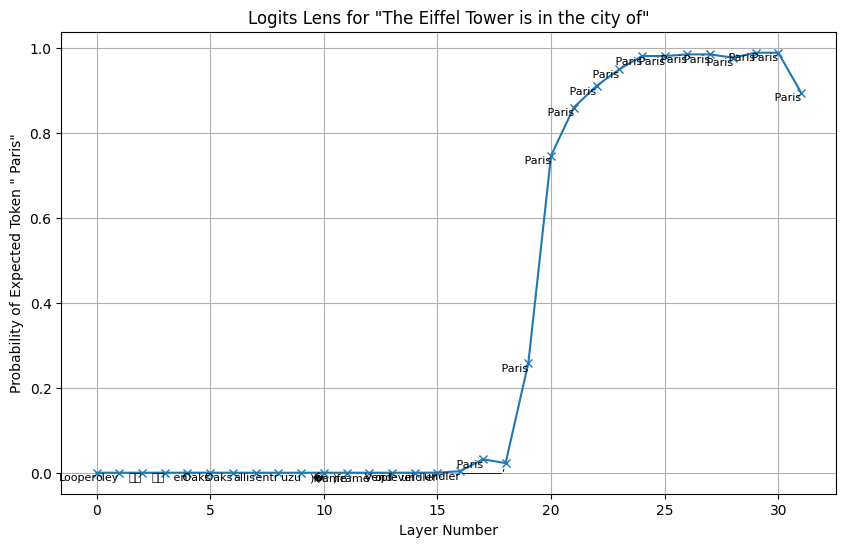

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
def plot__lens(logits_lens_all_probs,logits_lens_results,actual_output):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(logits_lens_all_probs)), logits_lens_all_probs, marker='x')

    for layer_number, next_token in enumerate(logits_lens_results):
        plt.text(layer_number, logits_lens_all_probs[layer_number], next_token, ha='right', va='top',fontsize=8)

    plt.xlabel('Layer Number')
    plt.ylabel(f'Probability of Expected Token "{actual_output}"')
    plt.title(f'Logits Lens for "{PROMPT}"')
    plt.grid(True)
    plt.show()

plot__lens(logits_lens_all_probs,logits_lens_results,actual_output)

In [7]:
def plot_rank(logits_lens_ranks_by_layer):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(logits_lens_ranks_by_layer)), logits_lens_ranks_by_layer, marker='x')
    for layer_number, rank in enumerate(logits_lens_ranks_by_layer):
        plt.text(layer_number, rank, rank, ha='right', va='top',fontsize=8)
    plt.xlabel('Layer Number')
    plt.ylabel('Rank of Expected Token')
    plt.title(f'Rank of Expected Token "{actual_output}"')
    plt.grid(True)
    plt.show()

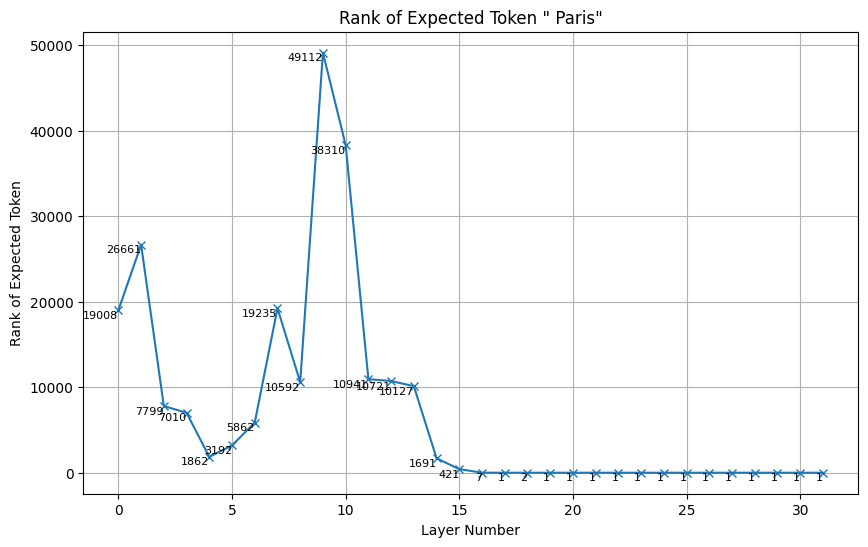

In [8]:
plot_rank(logits_lens_ranks_by_layer)

In [99]:
def submit_prompts(prompts_data):
    # Initialize lists to accumulate results
    all_prompts = []
    all_results = []
    all_probs = []
    all_expected = []
    all_layers = []
    all_ranks = []
    
    # Iterate over each prompt
    for prompt in prompts_data:
        # If a prompt is an empty string, skip it
        prompt = prompt[0]
        if not prompt:
            continue
        
        # Run the lens model on the prompt
        lens_output = run_lens(llama, prompt)
        
        # Accumulate results for each layer
        for layer_idx in range(len(lens_output[1])):
            all_prompts.append(prompt)
            all_results.append(lens_output[0][layer_idx])
            all_probs.append(lens_output[1][layer_idx])
            all_expected.append(lens_output[2])
            all_layers.append(layer_idx)
            all_ranks.append(lens_output[3][layer_idx])

    # Create DataFrame from accumulated results
    prompts_with_probs = pd.DataFrame(
        {
            "prompt": all_prompts,
            "layer": all_layers,
            "results": all_results,
            "probs": all_probs,
            "expected": all_expected,
        })
    
    prompts_with_ranks = pd.DataFrame(
        {
            "prompt": all_prompts,
            "layer": all_layers,
            "ranks": all_ranks,
            "expected": all_expected,
        })
    print('prompts_with_probs',prompts_with_probs)
    print('prompts_with_ranks',prompts_with_ranks)
    return prompts_with_probs,prompts_with_ranks

In [100]:
submit_prompts(["The Eiffel Tower is in the city of"])

2024-09-19 02:21:59,210 9ef0c3f2-7b08-4544-a6c2-4f0ee3eb86eb - RECEIVED: Your job has been received and is waiting approval.
2024-09-19 02:21:59,292 9ef0c3f2-7b08-4544-a6c2-4f0ee3eb86eb - APPROVED: Your job was approved and is waiting to be run.
2024-09-19 02:27:09,631 9ef0c3f2-7b08-4544-a6c2-4f0ee3eb86eb - RUNNING: Your job has started running.
2024-09-19 02:27:10,041 9ef0c3f2-7b08-4544-a6c2-4f0ee3eb86eb - COMPLETED: Your job has been completed.


logits_lens_ranks_by_layer:  [123346, 119791, 126484, 122938, 93740, 85895, 52308, 47498, 78750, 65089, 73821, 76253, 74126, 56499, 71470, 82356, 104461, 114195, 111386, 110605, 117091, 111805, 113891, 117946, 112341, 113484, 96593, 66051, 62738, 36906, 1282, 1]
prompts_with_probs    prompt  layer  results         probs expected
0       T      0      tog  5.028653e-08      rib
1       T      1    chine  7.799182e-08      rib
2       T      2     isel  2.046196e-08      rib
3       T      3     isel  4.095335e-08      rib
4       T      4      onu  4.423840e-07      rib
5       T      5     enze  6.054512e-07      rib
6       T      6     efon  1.973007e-06      rib
7       T      7     efon  1.976041e-06      rib
8       T      8     efon  6.644564e-07      rib
9       T      9     efon  1.222678e-06      rib
10      T     10     tees  9.249770e-07      rib
11      T     11      oví  9.161337e-07      rib
12      T     12     efon  1.035963e-06      rib
13      T     13     efon  1.863

(   prompt  layer  results         probs expected
 0       T      0      tog  5.028653e-08      rib
 1       T      1    chine  7.799182e-08      rib
 2       T      2     isel  2.046196e-08      rib
 3       T      3     isel  4.095335e-08      rib
 4       T      4      onu  4.423840e-07      rib
 5       T      5     enze  6.054512e-07      rib
 6       T      6     efon  1.973007e-06      rib
 7       T      7     efon  1.976041e-06      rib
 8       T      8     efon  6.644564e-07      rib
 9       T      9     efon  1.222678e-06      rib
 10      T     10     tees  9.249770e-07      rib
 11      T     11      oví  9.161337e-07      rib
 12      T     12     efon  1.035963e-06      rib
 13      T     13     efon  1.863446e-06      rib
 14      T     14     amac  1.077743e-06      rib
 15      T     15      xic  7.215531e-07      rib
 16      T     16      xic  2.671275e-07      rib
 17      T     17   Certif  1.348925e-07      rib
 18      T     18      xic  1.864246e-07      rib


In [97]:
import pandas as pd
prompts_with_probs_data = pd.DataFrame(
    {
        "prompt": ["The Eiffel Tower is in the city of", "Hi", "Maths is short for"]*3,
        "layer": [1,2,3]*3,
        "results": ["Paris", "London", "New York","Hello", "Hi", "Hey","Mathematics", "Maths", "Math"],
        "probs": [0.3, 0.4, 0.2, 0.9, 0.8, 0.7,0.6, 0.5, 0.6],
        "expected": ["Paris", "Hi", "Mathematics"]*3
    }
)

In [98]:
prompts_with_probs_data

,prompt,layer,results,probs,expected
0,The Eiffel Tower is in the city of,1,Paris,0.3,Paris
1,Hi,2,London,0.4,Hi
2,Maths is short for,3,New York,0.2,Mathematics
3,The Eiffel Tower is in the city of,1,Hello,0.9,Paris
4,Hi,2,Hi,0.8,Hi
5,Maths is short for,3,Hey,0.7,Mathematics
6,The Eiffel Tower is in the city of,1,Mathematics,0.6,Paris
7,Hi,2,Maths,0.5,Hi
8,Maths is short for,3,Math,0.6,Mathematics
